# YOLO Annotation Visualizer

This notebook visualizes bounding box annotations from the video annotation tool, showing:
- Full image frames with bounding boxes drawn
- Zoomed-in regions around each detection with 50px margins
- Side-by-side comparison for validation

## Import Required Libraries

Import necessary libraries for loading images, parsing annotations, and visualization.

In [ ]:
import os

In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from pathlib import Path
from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')

## Configuration

Set the paths to your annotation output directory and configure visualization parameters.

In [3]:
# Path to the output directory from the annotation tool
OUTPUT_DIR = "G:/2025-05-14_videos_annotated"  # Change this to your output directory

# Zoom margin (pixels around the detection)
MARGIN = 50

# Class mapping (should match the classes used in annotation)
CLASSES = {
    0: "Bat",
    1: "Bird", 
    2: "DragonFly",
    3: "Drone",
    4: "Plane",
    5: "Other"
}

# Color map for different classes (BGR format for OpenCV)
CLASS_COLORS = {
    0: (255, 0, 0),      # Bat - Blue
    1: (0, 255, 0),      # Bird - Green
    2: (0, 255, 255),    # DragonFly - Yellow
    3: (255, 0, 255),    # Drone - Magenta
    4: (255, 165, 0),    # Plane - Orange
    5: (128, 128, 128)   # Other - Gray
}

# Verify paths exist
images_dir = os.path.join(OUTPUT_DIR, "images")
labels_dir = os.path.join(OUTPUT_DIR, "labels")

print(f"Output directory: {OUTPUT_DIR}")
print(f"Images directory exists: {os.path.exists(images_dir)}")
print(f"Labels directory exists: {os.path.exists(labels_dir)}")

Output directory: G:/2025-05-14_videos_annotated
Images directory exists: True
Labels directory exists: True


## Helper Functions

Define functions to load annotations, draw bounding boxes, and extract zoomed regions.

In [4]:
def load_annotation(label_path):
    """
    Load YOLO format annotation from file.
    
    Returns: List of tuples (class_id, x_center, y_center, width, height) in normalized [0,1] format
    """
    bboxes = []
    if os.path.exists(label_path):
        with open(label_path, 'r') as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) >= 5:
                    class_id = int(parts[0])
                    x_center = float(parts[1])
                    y_center = float(parts[2])
                    width = float(parts[3])
                    height = float(parts[4])
                    bboxes.append((class_id, x_center, y_center, width, height))
    return bboxes

def normalized_to_pixel_coords(x_center, y_center, width, height, img_height, img_width):
    """
    Convert normalized YOLO coordinates to pixel coordinates.
    
    Returns: (x1, y1, x2, y2) - top-left and bottom-right corners
    """
    x_center_px = x_center * img_width
    y_center_px = y_center * img_height
    width_px = width * img_width
    height_px = height * img_height
    
    x1 = int(x_center_px - width_px / 2)
    y1 = int(y_center_px - height_px / 2)
    x2 = int(x_center_px + width_px / 2)
    y2 = int(y_center_px + height_px / 2)
    
    return x1, y1, x2, y2

def draw_bbox_on_image(image, bbox, class_id, thickness=2):
    """
    Draw a single bounding box on image.
    
    Args:
        image: OpenCV image (BGR)
        bbox: Tuple (class_id, x_center, y_center, width, height) in normalized format
        class_id: Class ID for the bounding box
        thickness: Line thickness for drawing
    
    Returns: Image with bbox drawn
    """
    img_height, img_width = image.shape[:2]
    class_id, x_center, y_center, width, height = bbox
    
    x1, y1, x2, y2 = normalized_to_pixel_coords(x_center, y_center, width, height, img_height, img_width)
    
    # Clamp to image bounds
    x1 = max(0, x1)
    y1 = max(0, y1)
    x2 = min(img_width, x2)
    y2 = min(img_height, y2)
    
    color = CLASS_COLORS.get(class_id, (255, 255, 255))
    cv2.rectangle(image, (x1, y1), (x2, y2), color, thickness)
    
    # Add class label
    label_text = f"{CLASSES.get(class_id, 'Unknown')}"
    label_size, _ = cv2.getTextSize(label_text, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
    cv2.rectangle(image, (x1, y1 - label_size[1] - 4), (x1 + label_size[0], y1), color, -1)
    cv2.putText(image, label_text, (x1, y1 - 2), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
    
    return image, (x1, y1, x2, y2)

def extract_zoom_region(image, x1, y1, x2, y2, margin=50):
    """
    Extract zoomed region around bounding box with margin.
    
    Args:
        image: OpenCV image (BGR)
        x1, y1, x2, y2: Bounding box coordinates in pixels
        margin: Margin in pixels around the bbox
    
    Returns: Cropped image, clipped coordinates
    """
    img_height, img_width = image.shape[:2]
    
    # Add margin and clamp to image bounds
    zoom_x1 = max(0, x1 - margin)
    zoom_y1 = max(0, y1 - margin)
    zoom_x2 = min(img_width, x2 + margin)
    zoom_y2 = min(img_height, y2 + margin)
    
    cropped = image[zoom_y1:zoom_y2, zoom_x1:zoom_x2].copy()
    
    # Convert bbox coords relative to cropped image
    rel_x1 = x1 - zoom_x1
    rel_y1 = y1 - zoom_y1
    rel_x2 = x2 - zoom_x1
    rel_y2 = y2 - zoom_y1
    
    return cropped, (rel_x1, rel_y1, rel_x2, rel_y2)

def get_annotated_images():
    """Get list of image files that have annotations."""
    images_dir = os.path.join(OUTPUT_DIR, "images")
    labels_dir = os.path.join(OUTPUT_DIR, "labels")

    # print(f"Images directory: {images_dir}")
    
    annotated_images = []
    
    if not os.path.exists(labels_dir):
        print("Labels directory does not exist.")
        return annotated_images
    
    # Find all label files
    for label_file in os.listdir(labels_dir):
        if label_file.endswith('.txt'):
            image_file = label_file.replace('.txt', '.jpg')
            image_path = os.path.join(images_dir, image_file)
            label_path = os.path.join(labels_dir, label_file)
            
            if os.path.exists(image_path):
                annotated_images.append((image_path, label_path))
    
    return sorted(annotated_images)

## Load Annotation Data

Find and list all annotated images with bounding boxes.

In [9]:
# Get all annotated images
import random

annotated_images = get_annotated_images()

print(f"Found {len(annotated_images)} annotated images")

# Display summary
if annotated_images:
    print("\nSample annotated images:")
    # take 5 random samples
    sampled_images = random.sample(annotated_images, min(5, len(annotated_images)))
    for i, (img_path, label_path) in enumerate(sampled_images):
        filename = os.path.basename(img_path)
        bboxes = load_annotation(label_path)
        print(f"  {i+1}. {filename} - {len(bboxes)} bounding box(es)")
else:
    print("No annotated images found. Please check the OUTPUT_DIR path.")

Found 322 annotated images

Sample annotated images:
  1. A03_01d940b5-20f4-3022-adf6-8dca0bdd3a6e_9.jpg - 3 bounding box(es)
  2. A03_0ae92411-89d0-3f81-abbd-6bb5e5a514a2_108.jpg - 1 bounding box(es)
  3. A03_0c76a221-2f90-33b3-af07-3aefd4d66097_105.jpg - 1 bounding box(es)
  4. A03_012146d8-f647-3393-b53f-8efc4bcf5c07_48.jpg - 1 bounding box(es)
  5. A03_0747e63b-2a46-3a08-83b0-7e0cb1068636_83.jpg - 2 bounding box(es)


## Visualize Annotations

Display annotated images with full frames and zoomed regions side-by-side.

**Instructions:**
- Adjust the `START_IDX` and `NUM_VISUALIZE` variables below to view different annotations
- Each row shows one annotated image with its bounding boxes
- Left: Full frame with all bounding boxes drawn
- Right: Zoomed region with 50px margin around each detection

Visualizing 5 images (indices 0-4)
Total annotated images available: 322


Image 1: A03_0000cfa6-1efa-350e-a754-5e23cfe9afaf_124.jpg
Detections: 2


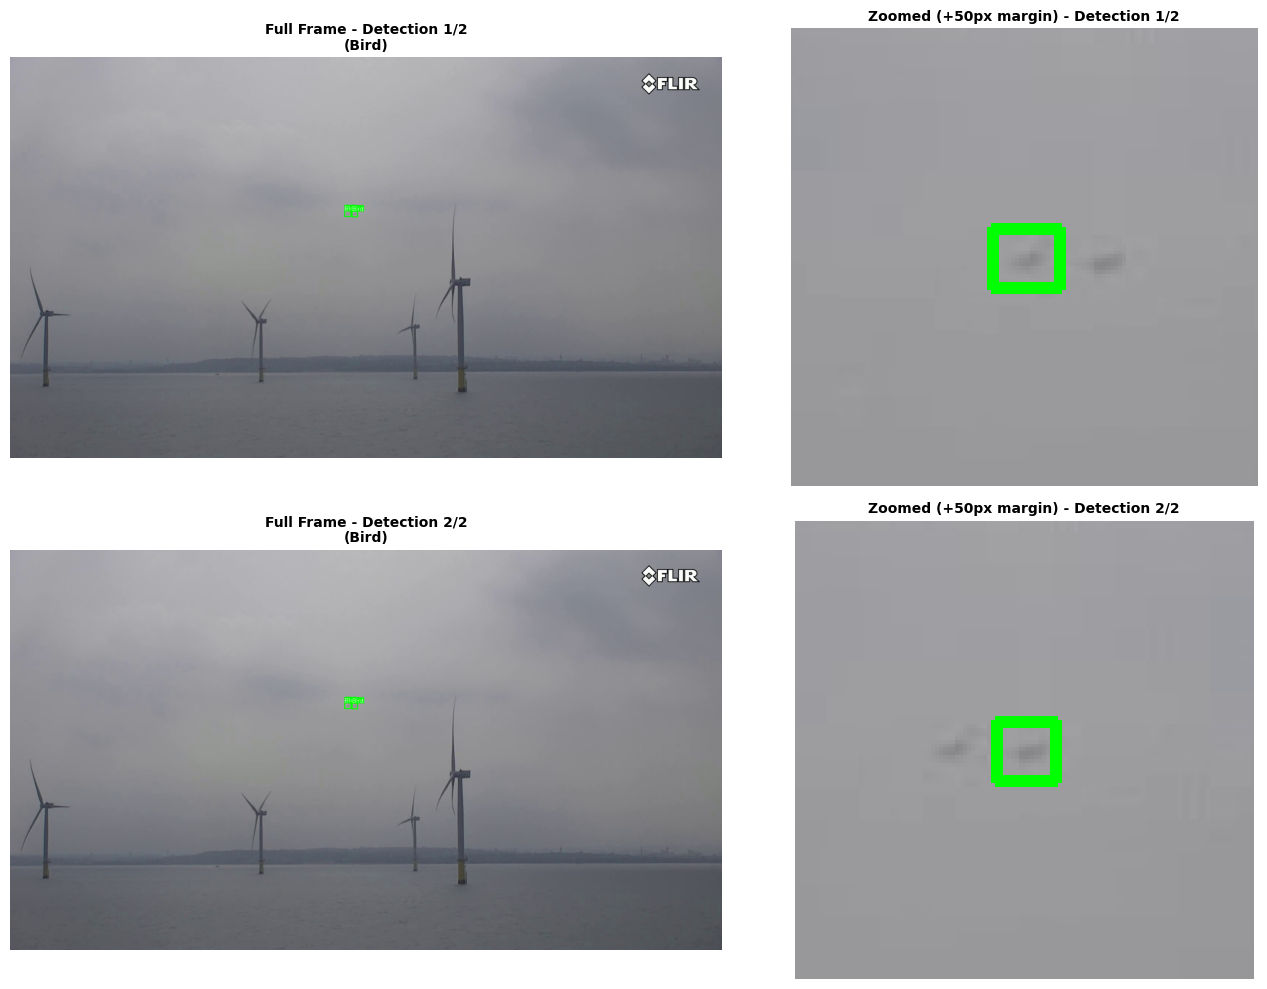

  Detection 1: Bird - Center: (0.4742, 0.3903), Size: (0.0089, 0.0139)
  Detection 2: Bird - Center: (0.4841, 0.3912), Size: (0.0078, 0.0139)

Image 2: A03_0000cfa6-1efa-350e-a754-5e23cfe9afaf_149.jpg
Detections: 2


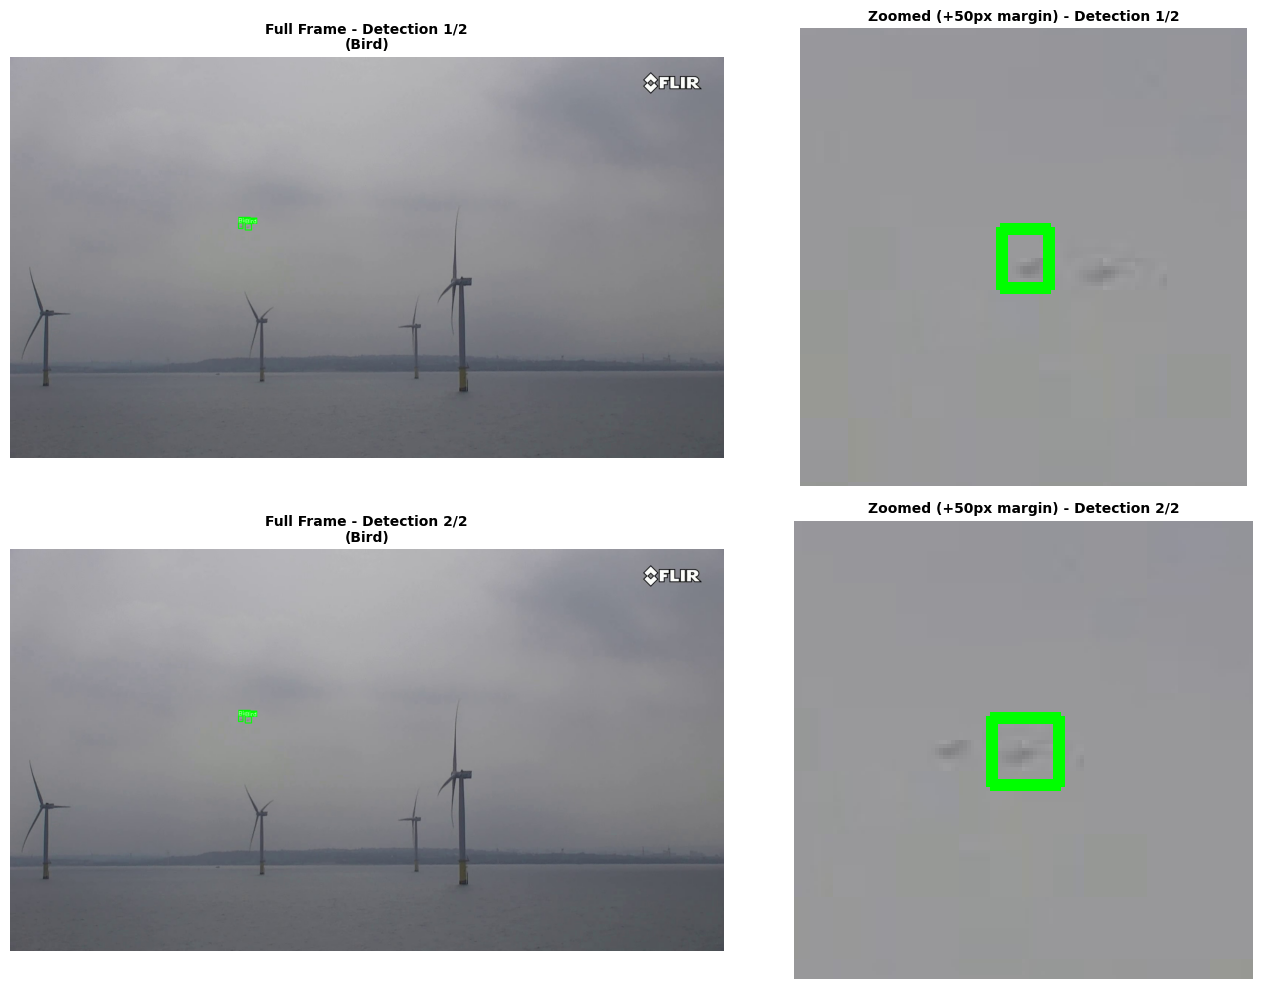

  Detection 1: Bird - Center: (0.3234, 0.4227), Size: (0.0063, 0.0139)
  Detection 2: Bird - Center: (0.3336, 0.4250), Size: (0.0089, 0.0148)

Image 3: A03_0000cfa6-1efa-350e-a754-5e23cfe9afaf_174.jpg
Detections: 2


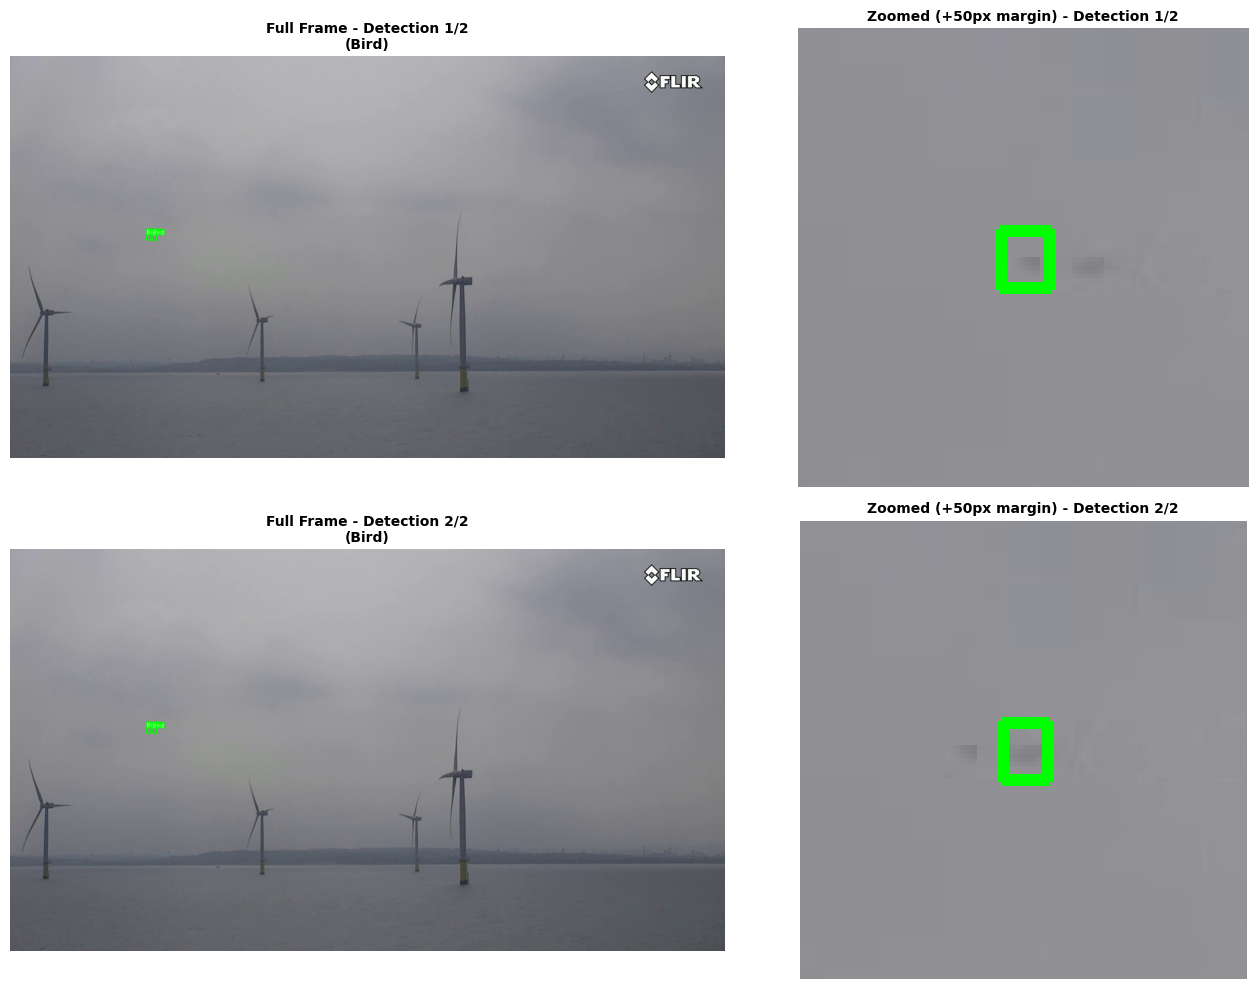

  Detection 1: Bird - Center: (0.1938, 0.4519), Size: (0.0063, 0.0130)
  Detection 2: Bird - Center: (0.2018, 0.4528), Size: (0.0057, 0.0130)

Image 4: A03_0000cfa6-1efa-350e-a754-5e23cfe9afaf_199.jpg
Detections: 2


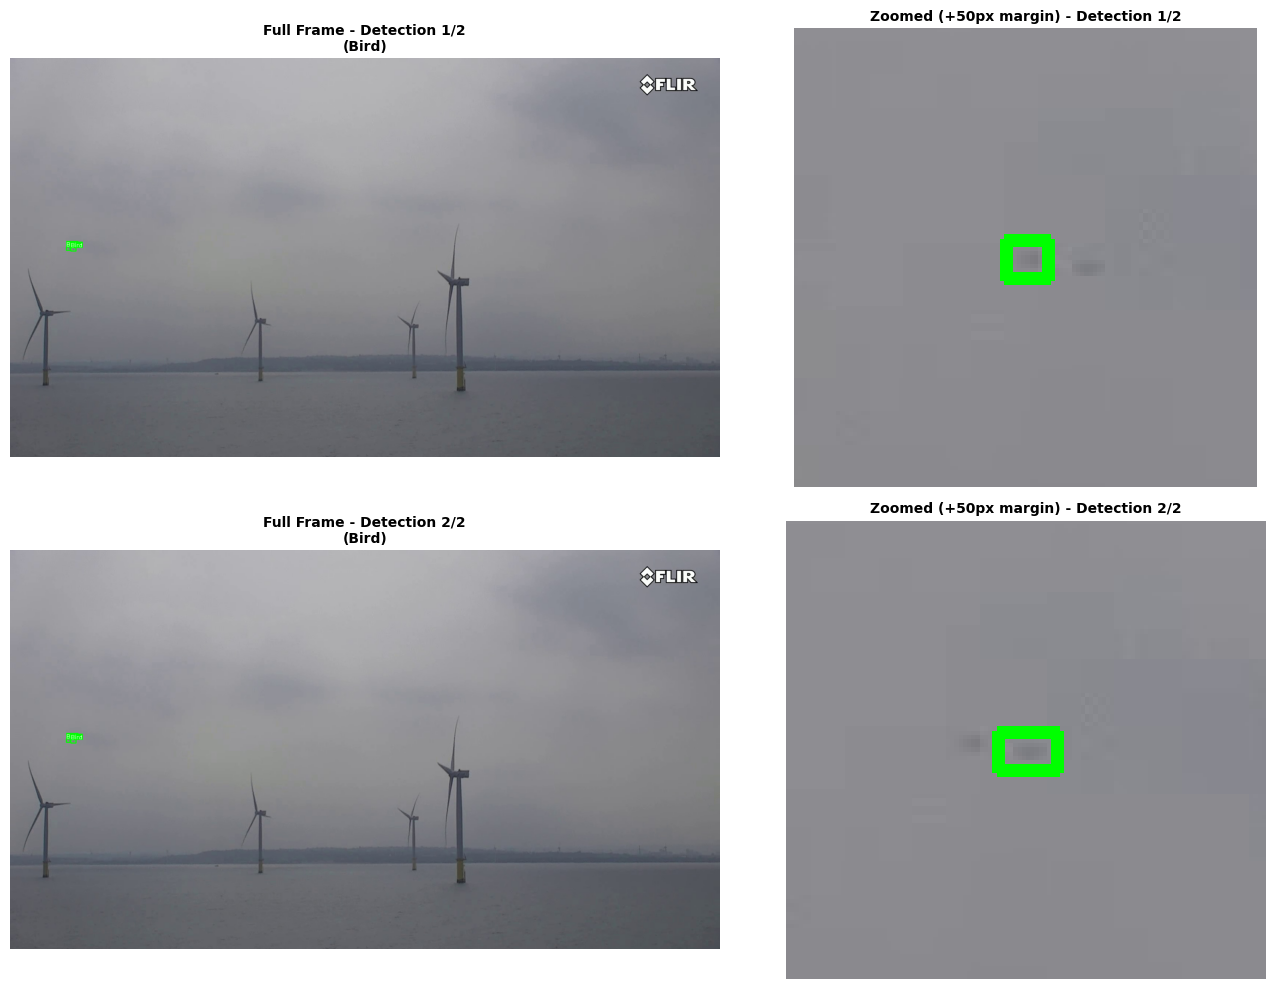

  Detection 1: Bird - Center: (0.0818, 0.4773), Size: (0.0052, 0.0083)
  Detection 2: Bird - Center: (0.0891, 0.4792), Size: (0.0073, 0.0083)

Image 5: A03_0000cfa6-1efa-350e-a754-5e23cfe9afaf_64.jpg
Detections: 2


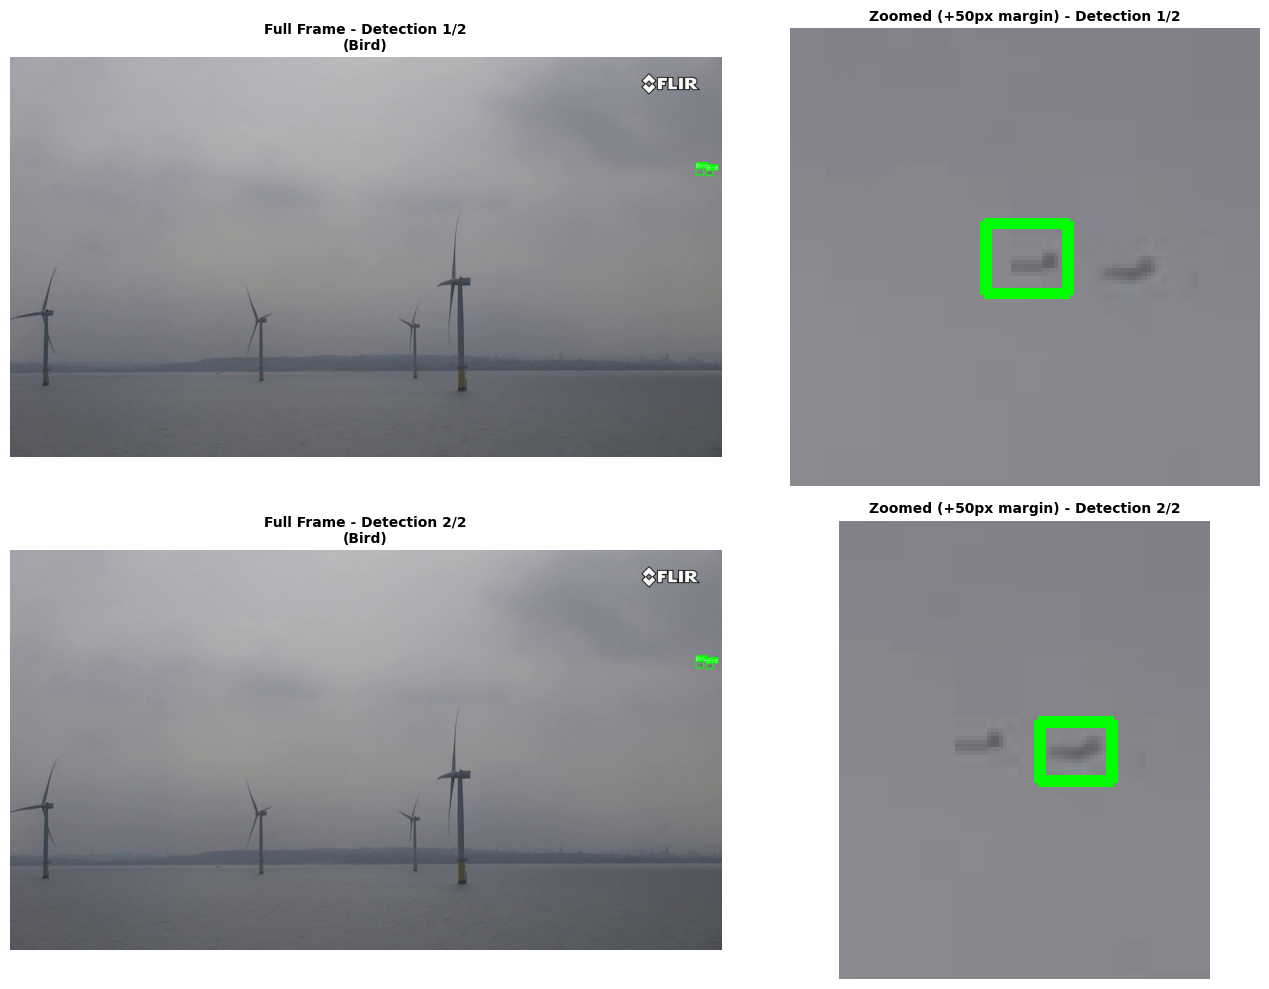

  Detection 1: Bird - Center: (0.9685, 0.2866), Size: (0.0109, 0.0157)
  Detection 2: Bird - Center: (0.9823, 0.2894), Size: (0.0094, 0.0139)

Visualization complete!


In [10]:
# Parameters for visualization
START_IDX = 0  # Start from which annotated image
NUM_VISUALIZE = 5  # How many to visualize

# Get the images to visualize
images_to_show = annotated_images[START_IDX : START_IDX + NUM_VISUALIZE]

print(f"Visualizing {len(images_to_show)} images (indices {START_IDX}-{START_IDX + len(images_to_show) - 1})")
print(f"Total annotated images available: {len(annotated_images)}\n")

# Visualize each annotated image
for img_idx, (image_path, label_path) in enumerate(images_to_show):
    # Load image and annotation
    img = cv2.imread(image_path)
    if img is None:
        print(f"Could not load image: {image_path}")
        continue
    
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    bboxes = load_annotation(label_path)
    
    if not bboxes:
        continue
    
    filename = os.path.basename(image_path)
    print(f"\n{'='*80}")
    print(f"Image {START_IDX + img_idx + 1}: {filename}")
    print(f"Detections: {len(bboxes)}")
    
    # Create figure for this image with subplots (one row per bbox)
    num_bboxes = len(bboxes)
    fig, axes = plt.subplots(num_bboxes, 2, figsize=(14, 5 * num_bboxes))
    
    # Handle single bbox case (axes won't be 2D)
    if num_bboxes == 1:
        axes = axes.reshape(1, -1)
    
    # Draw full image with all bboxes
    img_with_bboxes = img_rgb.copy()
    bbox_pixel_coords = []
    
    for bbox_idx, bbox in enumerate(bboxes):
        class_id = bbox[0]
        img_with_bboxes, (x1, y1, x2, y2) = draw_bbox_on_image(img_with_bboxes, bbox, class_id, thickness=2)
        bbox_pixel_coords.append((x1, y1, x2, y2, class_id))
    
    # Display full image on left column for each bbox
    for bbox_idx, (x1, y1, x2, y2, class_id) in enumerate(bbox_pixel_coords):
        ax_left = axes[bbox_idx, 0]
        ax_left.imshow(img_with_bboxes)
        ax_left.set_title(f"Full Frame - Detection {bbox_idx + 1}/{num_bboxes}\n({CLASSES.get(class_id, 'Unknown')})", fontsize=10, fontweight='bold')
        ax_left.axis('off')
        
        # Extract and display zoomed region on right
        ax_right = axes[bbox_idx, 1]
        zoomed_img, rel_coords = extract_zoom_region(img_rgb, x1, y1, x2, y2, margin=MARGIN)
        zoomed_img_copy = zoomed_img.copy()
        
        # Draw bbox on zoomed image
        rel_x1, rel_y1, rel_x2, rel_y2 = rel_coords
        color = CLASS_COLORS.get(class_id, (255, 255, 255))
        cv2.rectangle(zoomed_img_copy, (int(rel_x1), int(rel_y1)), (int(rel_x2), int(rel_y2)), color, 2)
        
        ax_right.imshow(zoomed_img_copy)
        ax_right.set_title(f"Zoomed (+{MARGIN}px margin) - Detection {bbox_idx + 1}/{num_bboxes}", fontsize=10, fontweight='bold')
        ax_right.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Print detection details
    for bbox_idx, bbox in enumerate(bboxes):
        class_id, x_center, y_center, width, height = bbox
        print(f"  Detection {bbox_idx + 1}: {CLASSES.get(class_id, 'Unknown')} - Center: ({x_center:.4f}, {y_center:.4f}), Size: ({width:.4f}, {height:.4f})")

print(f"\n{'='*80}")
print(f"Visualization complete!")

## Statistics and Summary

Generate statistics about the annotations across all images.

ANNOTATION STATISTICS
Total annotated images: 65
Total bounding boxes: 111
Average boxes per image: 1.71
Min boxes per image: 1
Max boxes per image: 3

Detections by class:
  Bat: 0 (0.0%)
  Bird: 111 (100.0%)
  DragonFly: 0 (0.0%)
  Drone: 0 (0.0%)
  Plane: 0 (0.0%)
  Other: 0 (0.0%)


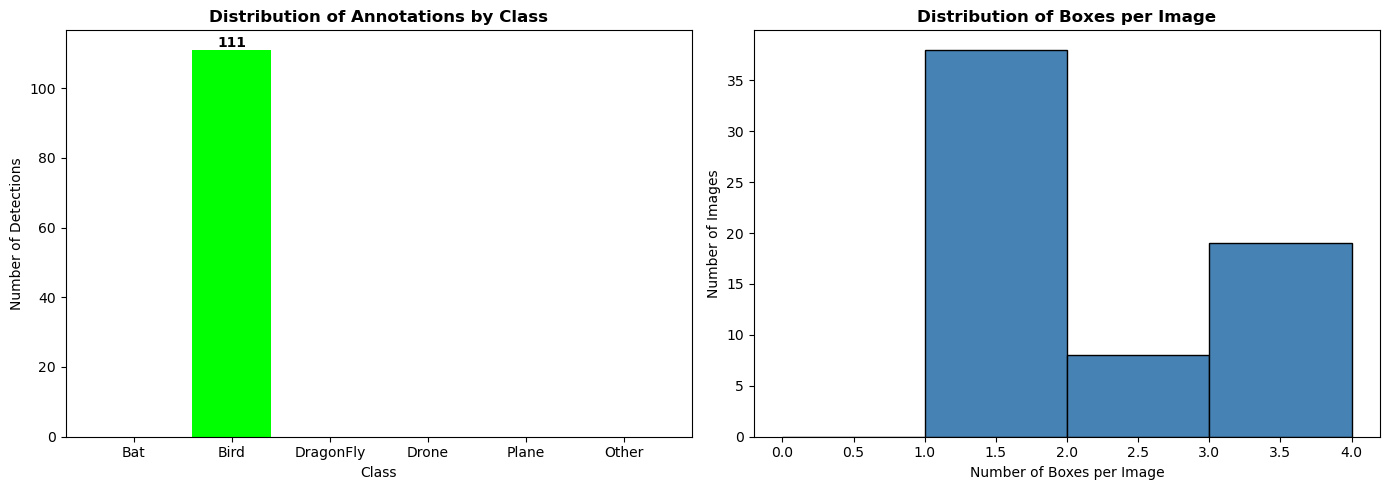

In [28]:
# Compute statistics
class_counts = {i: 0 for i in range(len(CLASSES))}
total_bboxes = 0
image_bbox_count = []

for img_path, label_path in annotated_images:
    bboxes = load_annotation(label_path)
    image_bbox_count.append(len(bboxes))
    total_bboxes += len(bboxes)
    
    for bbox in bboxes:
        class_id = bbox[0]
        class_counts[class_id] += 1

# Display statistics
print("ANNOTATION STATISTICS")
print("=" * 60)
print(f"Total annotated images: {len(annotated_images)}")
print(f"Total bounding boxes: {total_bboxes}")
print(f"Average boxes per image: {total_bboxes / len(annotated_images) if annotated_images else 0:.2f}")
print(f"Min boxes per image: {min(image_bbox_count) if image_bbox_count else 0}")
print(f"Max boxes per image: {max(image_bbox_count) if image_bbox_count else 0}")
print()
print("Detections by class:")
for class_id in sorted(class_counts.keys()):
    count = class_counts[class_id]
    percentage = (count / total_bboxes * 100) if total_bboxes > 0 else 0
    print(f"  {CLASSES.get(class_id, 'Unknown')}: {count} ({percentage:.1f}%)")

# Plot class distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart of class distribution
class_names = [CLASSES.get(i, f"Class {i}") for i in sorted(class_counts.keys())]
class_values = [class_counts[i] for i in sorted(class_counts.keys())]
colors = [CLASS_COLORS[i] for i in sorted(class_counts.keys())]
# Convert BGR to RGB for matplotlib
colors_rgb = [(b/255, g/255, r/255) for r, g, b in colors]

ax1.bar(class_names, class_values, color=colors_rgb)
ax1.set_title('Distribution of Annotations by Class', fontsize=12, fontweight='bold')
ax1.set_ylabel('Number of Detections')
ax1.set_xlabel('Class')
for i, v in enumerate(class_values):
    if v > 0:
        ax1.text(i, v, str(v), ha='center', va='bottom', fontweight='bold')

# Histogram of boxes per image
ax2.hist(image_bbox_count, bins=range(0, max(image_bbox_count) + 2), edgecolor='black', color='steelblue')
ax2.set_title('Distribution of Boxes per Image', fontsize=12, fontweight='bold')
ax2.set_xlabel('Number of Boxes per Image')
ax2.set_ylabel('Number of Images')

plt.tight_layout()
plt.show()